### --- Initial Data Loading and Preparation ---


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


try:
    fut = pd.read_csv("TRB_USDT/Archive/trb_usdt_futures_export.csv")
    spot = pd.read_csv("TRB_USDT/Archive/trb_usdt_spot_export.csv")
    trades = pd.read_csv("TRB_USDT/Archive/trb_usdt_trades_export.csv")

    for df in [spot, fut, trades]:
        df["time"] = pd.to_datetime(df["time"])
        df.sort_values("time", inplace=True)
        df.reset_index(drop=True, inplace=True)

    spot["mid_price"] = (spot["bid_price"] + spot["ask_price"]) / 2
    fut["mid_price"] = (fut["bid_price"] + fut["ask_price"]) / 2
    print("Data loaded successfully.")

except FileNotFoundError:
    print("Error: Make sure the CSV files are in the 'TRB_USDT/Archive/' directory.")
    exit()

Data loaded successfully.


### STEP 1: FIND TRUE SHOCK EVENTS

In [2]:
def find_shocks(df, shock_threshold=0.0007, window_ms=3):
    """
    Finds shock events based on:
    - Up-shocks are defined by the ASK price moving up.
    - Down-shocks are defined by the BID price moving down.
    (At first done by mid_price, but this is more accurate)
    """
    events = []
    t_ns = df["time"].astype("datetime64[ns]").values.astype(np.int64)
    ask_price = df["ask_price"].to_numpy()
    bid_price = df["bid_price"].to_numpy()
    window_ns = window_ms * 1_000_000

    window_end_indices = np.searchsorted(t_ns, t_ns + window_ns, side="right")

    i = 0
    while i < len(df) - 1:
        baseline_ask = ask_price[i]
        baseline_bid = bid_price[i]

        j_start = i + 1
        j_end = window_end_indices[i]

        found_shock = False
        for k in range(j_start, j_end):

            rel_change_ask = (ask_price[k] - baseline_ask) / baseline_ask
            if rel_change_ask >= shock_threshold:
                shock_dir = 1
                shock_size = rel_change_ask
                found_shock = True
                break

            rel_change_bid = (bid_price[k] - baseline_bid) / baseline_bid
            if rel_change_bid <= -shock_threshold:
                shock_dir = -1
                shock_size = abs(rel_change_bid)
                found_shock = True
                break

        if found_shock:
            event_data = df.iloc[k].to_dict()
            event_data["shock_dir"] = shock_dir
            event_data["abs_shock_size"] = shock_size
            events.append(event_data)
            i = k
        else:
            i += 1

    return pd.DataFrame(events)


def find_mid_price_shocks(df, shock_threshold=0.0007, window_ms=3):
    events = []
    t_ns = df["time"].astype("datetime64[ns]").values.astype(np.int64)
    mid_price= df["mid_price"].to_numpy()
    window_ns = window_ms * 1_000_000

    window_end_indices = np.searchsorted(t_ns, t_ns + window_ns, side="right")

    i = 0
    while i < len(df) - 1:
        baseline_mid = mid_price[i]
        j_start = i + 1
        j_end = window_end_indices[i]

        found_shock = False
        for k in range(j_start, j_end):

            rel_change_mid = (mid_price[k] - baseline_mid) / baseline_mid
            if rel_change_mid >= shock_threshold:
                shock_dir = 1
                shock_size = rel_change_mid
                found_shock = True
                break
            if rel_change_mid <= -shock_threshold:
                shock_dir = -1
                shock_size = abs(rel_change_mid)
                found_shock = True
                break

        if found_shock:
            event_data = df.iloc[k].to_dict()
            event_data["shock_dir"] = shock_dir
            event_data["abs_shock_size"] = shock_size
            events.append(event_data)
            i = k
        else:
            i += 1

    return pd.DataFrame(events)

In [3]:
# spot_shocks_df_mid = find_mid_price_shocks(spot)
# print(f"Found {len(spot_shocks_df_mid)} spot shock events.")
# fut_shocks_df_mid = find_mid_price_shocks(fut)
# print(f"Found {len(fut_shocks_df_mid)} futures shock events.")

spot_shocks_df= find_shocks(spot)
print(f"Found {len(spot_shocks_df)} spot shock events.")
fut_shocks_df = find_shocks(fut)
print(f"Found {len(fut_shocks_df)} futures shock.")

Found 15006 spot shock events.
Found 21457 futures shock.


### STEP 2: LABEL FOLLOW EVENTS BY SCANNING 5MS HORIZON

In [4]:
def label_follow_events(
    leader_shocks_df, follower_df, follower_name, reaction_ratio=0.25
):
    """
    Labels if a follower market reacts and captures the percentage change.
    - Uses a dynamic reaction threshold.
    - ask follows ask, vice versa.
    - adds a new column with the follower's percentage reaction.
    """
    shocks_df = leader_shocks_df.copy()

    t_ns_follower = follower_df["time"].astype("datetime64[ns]").values.astype(np.int64)
    follower_ask_prices = follower_df["ask_price"].to_numpy()
    follower_bid_prices = follower_df["bid_price"].to_numpy()

    horizon_ns = 5_000_000

    follow_col_name = f"{follower_name}_follow"
    percentage_col_name = f"{follower_name}_follow_percentage" 

    shocks_df[follow_col_name] = 0
    shocks_df[percentage_col_name] = 0.0 

    for idx, shock_event in shocks_df.iterrows():
        shock_time_ns = shock_event["time"].value

        dynamic_reaction_threshold = shock_event["abs_shock_size"] * reaction_ratio

        j0 = np.searchsorted(t_ns_follower, shock_time_ns, side="left")
        j1 = np.searchsorted(t_ns_follower, shock_time_ns + horizon_ns, side="right")

        if j0 >= j1:
            continue  

        baseline_idx = max(0, j0 - 1)
        baseline_follower_ask = follower_ask_prices[baseline_idx]
        baseline_follower_bid = follower_bid_prices[baseline_idx]

        if shock_event["shock_dir"] == 1:
            reaction_slice_ask = follower_ask_prices[j0:j1]
            max_reaction_ask = np.max(reaction_slice_ask)
            rel_up = (max_reaction_ask - baseline_follower_ask) / baseline_follower_ask

            if rel_up >= dynamic_reaction_threshold:
                shocks_df.loc[idx, follow_col_name] = 1
                shocks_df.loc[idx, percentage_col_name] = rel_up

        elif shock_event["shock_dir"] == -1:  
            reaction_slice_bid = follower_bid_prices[j0:j1]
            min_reaction_bid = np.min(reaction_slice_bid)
            rel_down = (min_reaction_bid - baseline_follower_bid) / baseline_follower_bid

            if rel_down <= -dynamic_reaction_threshold:
                shocks_df.loc[idx, follow_col_name] = -1
                shocks_df.loc[idx, percentage_col_name] = rel_down

    return shocks_df

spot_shocks_labeled = label_follow_events(
    spot_shocks_df, fut, "fut", reaction_ratio=0.1
)
fut_shocks_labeled = label_follow_events(
    fut_shocks_df, spot, "spot", reaction_ratio=0.1
)

### STEP 3: FEATURE ENGINEERING AND SAVING

In [5]:
def add_features_to_df(df, trade_df):
    df_out = df.copy()
    window_ns = 10 * 1_000_000
    t_event_ns = df_out["time"].astype("datetime64[ns]").values.astype(np.int64)
    t_trade_ns = trade_df["time"].astype("datetime64[ns]").values.astype(np.int64)
    q_trade = trade_df["quantity"].to_numpy()

    idx_right = np.searchsorted(t_trade_ns, t_event_ns, side="left")
    idx_left = np.searchsorted(t_trade_ns, t_event_ns - window_ns, side="left")
    df_out["past_trade_vol_10ms"] = [
        q_trade[l:r].sum() for l, r in zip(idx_left, idx_right)
    ]
    df_out["spread"] = df_out["ask_price"] - df_out["bid_price"]
    df_out["time_since_prev_shock"] = df_out["time"].diff().dt.total_seconds().fillna(0)
    hour = df_out["time"].dt.hour
    df_out["hour_sin"] = np.sin(2 * np.pi * hour / 24) # not needed for one day of data
    df_out["hour_cos"] = np.cos(2 * np.pi * hour / 24) # not needed for one day of data

    return df_out

In [6]:
Path("outputs").mkdir(exist_ok=True)

model1_df = add_features_to_df(spot_shocks_labeled, trades)

model1_df["target_fut_followed"] = (
    model1_df["shock_dir"] == model1_df["fut_follow"]
).astype(int)

model1_df.rename(
    columns={"fut_follow_percentage": "target_fut_percentage"}, inplace=True
)

model1_df.to_csv("outputs/model1_spot_led_microstructure.csv", index=False)
print(
    f"Saved {len(model1_df)} rows for Model 1 (Spot -> Fut)"
)

print("Preview of new columns for Model 1:")
print(
    model1_df[
        ["shock_dir", "fut_follow", "target_fut_followed", "target_fut_percentage"]
    ].head()
)

# Same logic for Model 2: Fut -> Spot
model2_df = add_features_to_df(fut_shocks_labeled, trades)
model2_df["target_spot_followed"] = (
    model2_df["shock_dir"] == model2_df["spot_follow"]
).astype(int)

model2_df.rename(
    columns={"spot_follow_percentage": "target_spot_percentage"}, inplace=True
)

model2_df.to_csv("outputs/model2_fut_led_microstructure.csv", index=False)
print(
    f"Saved {len(model2_df)} rows for Model 2 (Fut -> Spot)"
)
print("Preview of new columns for Model 2:")
print(
    model2_df[
        ["shock_dir", "spot_follow", "target_spot_followed", "target_spot_percentage"]
    ].head()
)

Saved 15006 rows for Model 1 (Spot -> Fut)
Preview of new columns for Model 1:
   shock_dir  fut_follow  target_fut_followed  target_fut_percentage
0          1           1                    1               0.002215
1          1           1                    1               0.000899
2          1           1                    1               0.001193
3          1           1                    1               0.000504
4          1           1                    1               0.001167
Saved 21457 rows for Model 2 (Fut -> Spot)
Preview of new columns for Model 2:
   shock_dir  spot_follow  target_spot_followed  target_spot_percentage
0          1            1                     1                0.000922
1          1            1                     1                0.000921
2          1            1                     1                0.000460
3          1            1                     1                0.000460
4         -1           -1                     1               -0.000

In [7]:
model2_df[["target_spot_followed"]].describe()

,target_spot_followed
count,21457.000000
mean,0.726290
std,0.445872
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


### STEP 4: ANALYSIS AND PLOTTING

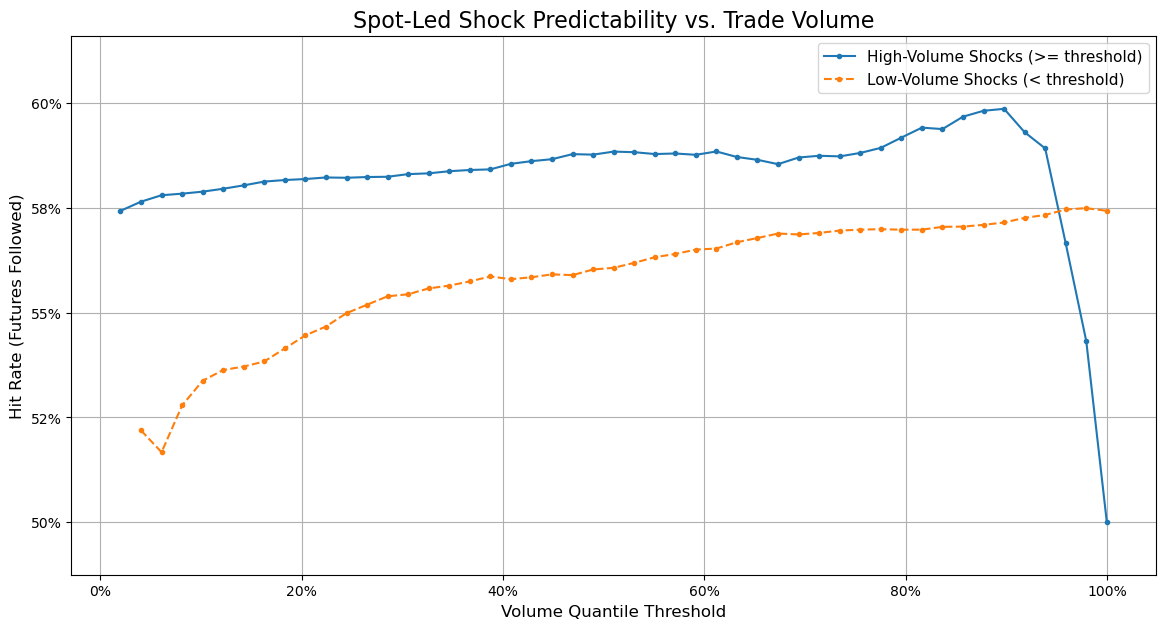

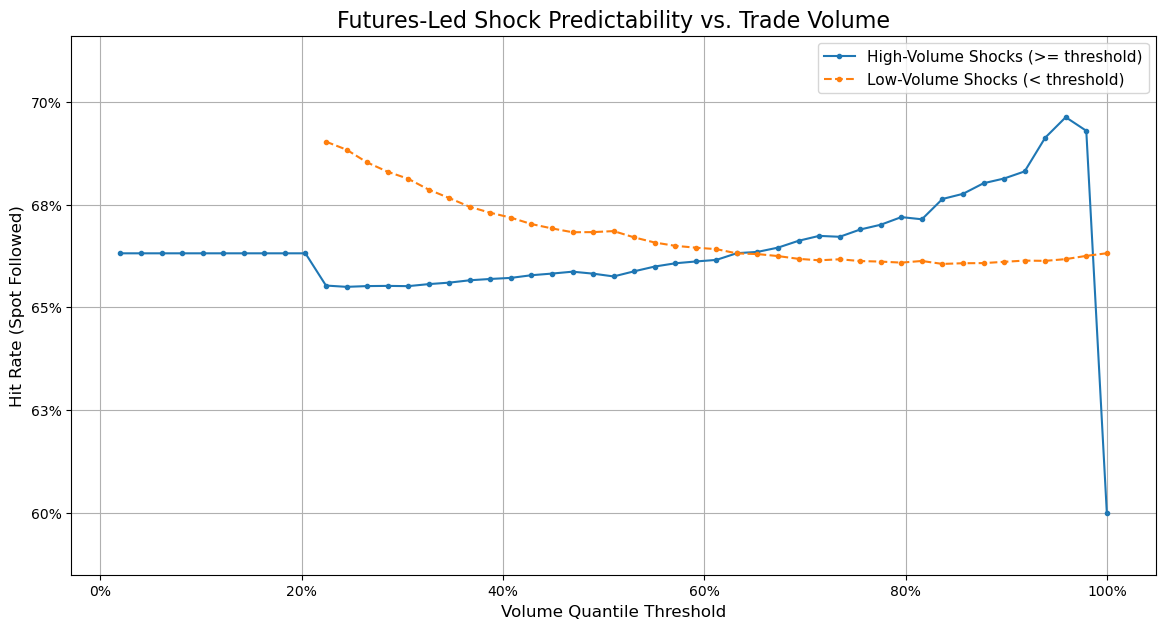


Max hit-rate for Spot-Led, high-volume shocks: 69.71%
Max hit-rate for Futures-Led, high-volume shocks: 79.25%


In [8]:
def lead_success_spot(df):
    if len(df) == 0:
        return np.nan
    return df["target_fut_followed"].mean()


def lead_success_fut(df):
    if len(df) == 0:
        return np.nan
    return df["target_spot_followed"].mean()


percentiles = np.linspace(0.02, 1, 49)
spot_high_rate, spot_low_rate = [], []
fut_high_rate, fut_low_rate = [], []
volume_feature = "past_trade_vol_10ms"

for p in percentiles:
    thr_s = model1_df[volume_feature].quantile(p)
    high_vol_spot_shocks = model1_df[model1_df[volume_feature] >= thr_s]
    low_vol_spot_shocks = model1_df[model1_df[volume_feature] < thr_s]
    spot_high_rate.append(lead_success_spot(high_vol_spot_shocks))
    spot_low_rate.append(lead_success_spot(low_vol_spot_shocks))

    thr_f = model2_df[volume_feature].quantile(p)
    high_vol_fut_shocks = model2_df[model2_df[volume_feature] >= thr_f]
    low_vol_fut_shocks = model2_df[model2_df[volume_feature] < thr_f]
    fut_high_rate.append(lead_success_fut(high_vol_fut_shocks))
    fut_low_rate.append(lead_success_fut(low_vol_fut_shocks))


plt.figure(figsize=(14, 7))


plt.plot(
    percentiles,
    spot_high_rate,
    marker=".",
    linestyle="-",
    label="High-Volume Shocks (>= threshold)",
)
plt.plot(
    percentiles,
    spot_low_rate,
    marker=".",
    linestyle="--",
    label="Low-Volume Shocks (< threshold)",
)


plt.xlabel("Volume Quantile Threshold", fontsize=12)
plt.ylabel("Hit Rate (Futures Followed)", fontsize=12)
plt.title(
    "Spot-Led Shock Predictability vs. Trade Volume", fontsize=16
)
plt.legend(fontsize=11)
plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])
plt.gca().set_xticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_xticks()])

all_spot_rates = spot_high_rate + spot_low_rate
valid_spot_rates = [r for r in all_spot_rates if pd.notna(r)]
if valid_spot_rates:  
    plt.ylim(bottom=min(valid_spot_rates) * 0.95, top=max(valid_spot_rates) * 1.05)
plt.grid()
plt.show()


plt.figure(figsize=(14, 7))
plt.plot(
    percentiles,
    fut_high_rate,
    marker=".",
    linestyle="-",
    label="High-Volume Shocks (>= threshold)",
)
plt.plot(
    percentiles,
    fut_low_rate,
    marker=".",
    linestyle="--",
    label="Low-Volume Shocks (< threshold)",
)
plt.xlabel("Volume Quantile Threshold", fontsize=12)
plt.ylabel("Hit Rate (Spot Followed)", fontsize=12)

plt.title(
    "Futures-Led Shock Predictability vs. Trade Volume",
    fontsize=16,
)

plt.legend(fontsize=11)
plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])
plt.gca().set_xticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_xticks()])

all_fut_rates = fut_high_rate + fut_low_rate
valid_fut_rates = [r for r in all_fut_rates if pd.notna(r)]
if valid_fut_rates:  # Only set limit if there are valid rates
    plt.ylim(bottom=min(valid_fut_rates) * 0.95, top=max(valid_fut_rates) * 1.05)
plt.grid()
plt.show()

print(
    f"\nMax hit-rate for Spot-Led, high-volume shocks: {np.nanmax(spot_high_rate):.2%}"
)
print(
    f"Max hit-rate for Futures-Led, high-volume shocks: {np.nanmax(fut_high_rate):.2%}"
)

Descriptive statistics for noise events:

--- spot-led (count: 5275) ---
       abs_shock_size       spread  past_trade_vol_10ms
count     5275.000000  5275.000000          5275.000000
mean         0.001054     0.081683            52.658299
std          0.000668     0.057976           156.094496
min          0.000704     0.010000             0.000000
25%          0.000782     0.050000             6.467000
50%          0.000842     0.070000            20.599000
75%          0.001097     0.100000            53.503000
max          0.026250     1.090000          3372.588000

--- fut-led (count: 5873) ---
       abs_shock_size       spread  past_trade_vol_10ms
count     5873.000000  5873.000000          5873.000000
mean         0.001147     0.075860            30.826838
std          0.001328     0.114324           100.613188
min          0.000700     0.001000             0.000000
25%          0.000762     0.040000             1.000000
50%          0.000876     0.055000             9.253000


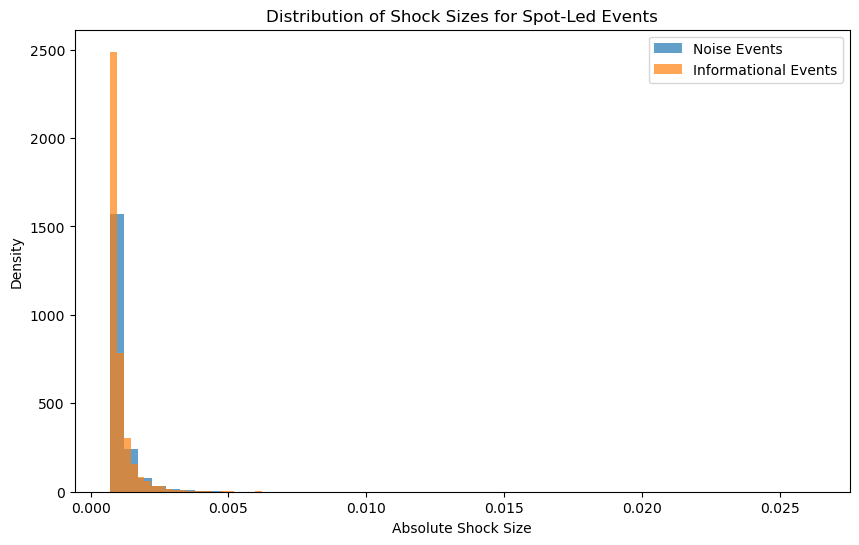

In [9]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
noise_spot = model1_df[model1_df["fut_follow"] == 0].copy()
noise_fut = model2_df[model2_df["spot_follow"] == 0].copy()

print("Descriptive statistics for noise events:")
stats_cols = ["abs_shock_size", "spread", "past_trade_vol_10ms"]
for df, name in [(noise_spot, "spot-led"), (noise_fut, "fut-led")]:
    print(f"\n--- {name} (count: {len(df)}) ---")
    print(df[stats_cols].describe())

plt.figure(figsize=(10, 6))
informational_spot = model1_df[model1_df["fut_follow"] == 1]
plt.hist(
    noise_spot["abs_shock_size"], bins=50, alpha=0.7, label="Noise Events", density=True
)
plt.hist(
    informational_spot["abs_shock_size"],
    bins=50,
    alpha=0.7,
    label="Informational Events",
    density=True,
)
plt.xlabel("Absolute Shock Size")
plt.ylabel("Density")
plt.title("Distribution of Shock Sizes for Spot-Led Events")
plt.legend()
plt.show()

# features = [
#     "time_since_prev_shock",
#     "abs_shock_size",
#     "past_trade_vol_10ms",
#     "spread",
#     "shock_dir",
# ]
# X_reg = noise_spot[features]
# 
# kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
# noise_spot["regime"] = kmeans.fit_predict(X_reg)
# 
# tsne = TSNE(n_components=2, random_state=42)
# embedding = tsne.fit_transform(X_reg)
# 
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     c=noise_spot["regime"],
#     s=15,
#     cmap="viridis",
#     alpha=0.8,
# )
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
# plt.title("t-SNE Visualization of Spot-Led Noise Regimes")
# plt.legend(
#     handles=scatter.legend_elements()[0], labels=["Regime 0", "Regime 1", "Regime 2"]
# )
# plt.show()